In [1]:
import numpy as np
import random

In [2]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist

In [3]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]

    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):

    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')

    return pairs, y


In [4]:
(train_images, train_labels), (test_images,
                               test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255.0
test_images /= 255.0


In [5]:
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [6]:
import matplotlib.pyplot as plt


def plot_image(image):
    plt.imshow(image)

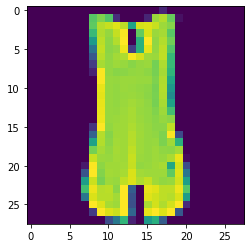

In [7]:
image_no = 2
plot_image(tr_pairs[image_no][0])
plot_image(tr_pairs[image_no][1])

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop


def initialize_base_network():
    input = Input(shape=(
        28,
        28,
    ), name='base_input')
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)


In [9]:
def euclidean_distance(vects):
    x, y = vects
    sum_sq = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_sq, K.epsilon()))

In [10]:
def euclidean_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [11]:
base_network = initialize_base_network()
plot_model(base_network)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [12]:
input_a = Input(shape=(
    28,
    28,
), name='left_input')
vec_output_a = base_network(input_a)

input_b = Input(shape=(
    28,
    28,
), name='right_input')
vec_output_b = base_network(input_b)

In [13]:
output = Lambda(
    euclidean_distance,
    name='output_layer',
    output_shape=euclidean_dist_output_shape)([vec_output_a, vec_output_b])
model = Model([input_a, input_b], output)

In [14]:
def contrastive_loss_with_margin(margin):

    def contrastive_loss(y_true, y_pred):
        sq_pred = K.square(y_pred)
        margin_sq = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * sq_pred + (1 - y_true) * margin_sq)

    return contrastive_loss

In [15]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(1), optimizer=rms)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]],
                    tr_y,
                    epochs=20,
                    batch_size=128,
                    validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))
loss = model.evaluate(x=[ts_pairs[:, 0], ts_pairs[:, 1]], y=ts_y)


Epoch 1/20
938/938 [==============================] - 8s 6ms/step - loss: 0.1155 - val_loss: 0.0844
Epoch 2/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0805 - val_loss: 0.0729
Epoch 3/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0713 - val_loss: 0.0702
Epoch 4/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0660 - val_loss: 0.0716
Epoch 5/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0638 - val_loss: 0.0684
Epoch 6/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0617 - val_loss: 0.0659
Epoch 7/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0603 - val_loss: 0.0666
Epoch 8/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0593 - val_loss: 0.0663
Epoch 9/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0577 - val_loss: 0.0645
Epoch 10/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0570 - val_loss: 0.0643

In [16]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(y_true == pred)

In [17]:
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

In [18]:
train_accuracy, test_accuracy

(0.06305217536256043, 0.09014014014014014)